# GAT 网络

以下实现一个多头注意力图神经网络，是对论文 《Graph Attention Networks》Petar Veličković, et al., 2018的复现

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
 
class GATLayer(nn.Module):
 
    def __init__(self,c_in,c_out,
                num_heads=1, concat_heads=True, alpha=0.2):
        """
        :param c_in: 输入特征维度
        :param c_out: 输出特征维度
        :param num_heads: 多头的数量
        :param concat_heads: 是否拼接多头计算的结果
        :param alpha: LeakyReLU的参数
        :return:
        """
        super().__init__()
        self.num_heads = num_heads
        self.concat_heads = concat_heads
        if self.concat_heads:
            assert c_out % num_heads ==0,"输出特征数必须是头数的倍数！"
            c_out = c_out // num_heads
 
        #参数
        self.projection = nn.Linear(c_in,c_out*num_heads) #有几个头，就需要将c_out扩充几倍
        self.a = nn.Parameter(torch.Tensor(num_heads,2*c_out)) #用于计算注意力的参数，由于对两节点拼接后的向量进行操作，所以2*c_out
        self.leakrelu = nn.LeakyReLU(alpha) #激活层
 
        #参数初始化
        nn.init.xavier_uniform_(self.projection.weight.data, gain=1.414)
        nn.init.xavier_uniform_(self.a.data, gain=1.414) # 近似sqrt(2)
 
    def forward(self,node_feats,adj_matrix,print_attn_probs=False):
        """
        输入：
        :param self:
        :param node_feats: 节点的特征表示
        :param adj_matrix: 邻接矩阵
        :param print_attn_probs: 是否打印注意力
        :return:
        """
        batch_size,num_nodes = node_feats.size(0),node_feats.size(1)
        # batch_size是节点的特征维度，num_nodes是节点数
        #将节点初始输入进行权重运算
        node_feats = self.projection(node_feats)
        #扩展出多头数量的维度
        node_feats = node_feats.view(batch_size,num_nodes,self.num_heads,-1)

        # 获取所有顶点对拼接而成的特征向量 a_input
        edges = adj_matrix.nonzero(as_tuple=False)  # 返回所有邻接矩阵中值不为 0 的 index，即所有连接的边对应的两个顶点
        node_feats_flat = node_feats.view(batch_size * num_nodes, self.num_heads, -1)  # 将所有 batch_size 的节点拼接

        edge_indices_row = edges[:, 0] * num_nodes  + edges[:, 1]  # 获取边对应的第一个顶点 index
        edge_indices_col = edges[:, 0] * num_nodes  + edges[:, 2]  # 获取边对应的第二个顶点 index

        a_input = torch.cat([
        torch.index_select(input=node_feats_flat, index=edge_indices_row, dim=0), # 基于边对应的第一个顶点的 index 获取其特征值
            torch.index_select(input=node_feats_flat, index=edge_indices_col, dim=0)  # 基于边对应的第二个顶点的 index 获取其特征值
        ], dim=-1)  # 两者拼接

        # 基于权重 a 进行注意力计算
        attn_logits = torch.einsum('bhc,hc->bh', a_input, self.a)
        # LeakyReLU 计算
        attn_logits = self.leakrelu(attn_logits)

        # 将注意力权转换为矩阵的形式
        attn_matrix = attn_logits.new_zeros(adj_matrix.shape + (self.num_heads,)).fill_(-9e15)
        attn_matrix[adj_matrix[..., None].repeat(1, 1, 1, self.num_heads) == 1] = attn_logits.reshape(-1)

        # Softmax 计算转换为概率
        attn_probs = F.softmax(attn_matrix, dim=2)
        if print_attn_probs:
            print("注意力权重:\n", attn_probs.permute(0, 3, 1, 2))
        # 对每个节点进行注意力加权相加的计算
        node_feats = torch.einsum('bijh,bjhc->bihc', attn_probs, node_feats)

        # 根据是否将多头的计算结果拼接与否进行不同操作
        if self.concat_heads:  # 拼接
            node_feats = node_feats.reshape(batch_size, num_nodes, -1)
        else:  # 平均
            node_feats = node_feats.mean(dim=2)

        return node_feats 


举一个例子

In [4]:
layer = GATLayer(2, 2, num_heads=2)
layer.projection.weight.data = torch.Tensor([[1., 0.], [0., 1.]])
layer.projection.bias.data = torch.Tensor([0., 0.])
layer.a.data = torch.Tensor([[-0.2, 0.3], [0.1, -0.1]])
node_feats = torch.arange(8, dtype=torch.float32).view(1, 4, 2)
adj_matrix = torch.Tensor([[[1, 1, 0, 0],
                                    [1, 1, 1, 1],
                                    [0, 1, 1, 1],
                                    [0, 1, 1, 1]]])
with torch.no_grad():
    out_feats = layer(node_feats, adj_matrix, print_attn_probs=True)


print("节点特征:\n", node_feats)
print("添加自连接的邻接矩阵:\n", adj_matrix)
print("节点输出特征:\n", out_feats)

注意力权重:
 tensor([[[[0.3543, 0.6457, 0.0000, 0.0000],
          [0.1096, 0.1450, 0.2642, 0.4813],
          [0.0000, 0.1858, 0.2885, 0.5257],
          [0.0000, 0.2391, 0.2696, 0.4913]],

         [[0.5100, 0.4900, 0.0000, 0.0000],
          [0.2975, 0.2436, 0.2340, 0.2249],
          [0.0000, 0.3838, 0.3142, 0.3019],
          [0.0000, 0.4018, 0.3289, 0.2693]]]])
节点特征:
 tensor([[[0., 1.],
         [2., 3.],
         [4., 5.],
         [6., 7.]]])
添加自连接的邻接矩阵:
 tensor([[[1., 1., 0., 0.],
         [1., 1., 1., 1.],
         [0., 1., 1., 1.],
         [0., 1., 1., 1.]]])
节点输出特征:
 tensor([[[1.2913, 1.9800],
         [4.2344, 3.7725],
         [4.6798, 4.8362],
         [4.5043, 4.7351]]])


再举例说明。首先加载Planetoid数据集：

In [1]:
from torch_geometric.datasets import Planetoid
from torch_geometric.transforms import NormalizeFeatures

dataset = Planetoid(root='data/Planetoid', name='Cora', transform=NormalizeFeatures())

print(f'Dataset: {dataset}:')
print('======================')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')

data = dataset[0]  # Get the first graph object.
print(data)

Dataset: Cora():
Number of graphs: 1
Number of features: 1433
Number of classes: 7
Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])


In [6]:
import torch
from torch_geometric.nn import GATConv
import torch.nn.functional as F

class GAT(torch.nn.Module):
    def __init__(self, hidden_channels, heads):
        super().__init__()
        torch.manual_seed(1234567)
        self.conv1 = GATConv(dataset.num_features, hidden_channels,heads)
        self.conv2 = GATConv(heads*hidden_channels, dataset.num_classes,heads)

    def forward(self, x, edge_index):
        x = F.dropout(x, p=0.6, training=self.training)
        x = self.conv1(x, edge_index)
        x = F.elu(x)
        x = F.dropout(x, p=0.6, training=self.training)
        x = self.conv2(x, edge_index)
        return x

model = GAT(hidden_channels=8, heads=8)
print(model)



GAT(
  (conv1): GATConv(1433, 8, heads=8)
  (conv2): GATConv(64, 7, heads=8)
)


In [8]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.005, weight_decay=5e-4)
criterion = torch.nn.CrossEntropyLoss()

def train():
      model.train()
      optimizer.zero_grad()
      out = model(data.x, data.edge_index)
      loss = criterion(out[data.train_mask], data.y[data.train_mask])
      loss.backward()
      optimizer.step()
      return loss

def test(mask):
      model.eval()
      out = model(data.x, data.edge_index)
      pred = out.argmax(dim=1)
      correct = pred[mask] == data.y[mask]
      acc = int(correct.sum()) / int(mask.sum())
      return acc

In [9]:
val_acc_all = []
test_acc_all = []

for epoch in range(1, 101):
    loss = train()
    val_acc = test(data.val_mask)
    test_acc = test(data.test_mask)
    val_acc_all.append(val_acc)
    test_acc_all.append(test_acc)
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, Val: {val_acc:.4f}, Test: {test_acc:.4f}')

Epoch: 001, Loss: 4.0245, Val: 0.3520, Test: 0.3770
Epoch: 002, Loss: 3.9926, Val: 0.4760, Test: 0.5240
Epoch: 003, Loss: 3.9555, Val: 0.5000, Test: 0.5560
Epoch: 004, Loss: 3.9104, Val: 0.5440, Test: 0.5740
Epoch: 005, Loss: 3.8645, Val: 0.5500, Test: 0.5870
Epoch: 006, Loss: 3.8111, Val: 0.5560, Test: 0.5800
Epoch: 007, Loss: 3.7478, Val: 0.5460, Test: 0.5730
Epoch: 008, Loss: 3.6821, Val: 0.5320, Test: 0.5650
Epoch: 009, Loss: 3.6151, Val: 0.5280, Test: 0.5610
Epoch: 010, Loss: 3.5253, Val: 0.5220, Test: 0.5570
Epoch: 011, Loss: 3.4305, Val: 0.5080, Test: 0.5490
Epoch: 012, Loss: 3.3468, Val: 0.5040, Test: 0.5430
Epoch: 013, Loss: 3.2313, Val: 0.4900, Test: 0.5280
Epoch: 014, Loss: 3.1400, Val: 0.4800, Test: 0.5180
Epoch: 015, Loss: 3.0162, Val: 0.4700, Test: 0.5080
Epoch: 016, Loss: 2.9145, Val: 0.4620, Test: 0.4990
Epoch: 017, Loss: 2.7860, Val: 0.4520, Test: 0.4940
Epoch: 018, Loss: 2.6948, Val: 0.4340, Test: 0.4820
Epoch: 019, Loss: 2.5836, Val: 0.4220, Test: 0.4730
Epoch: 020, 

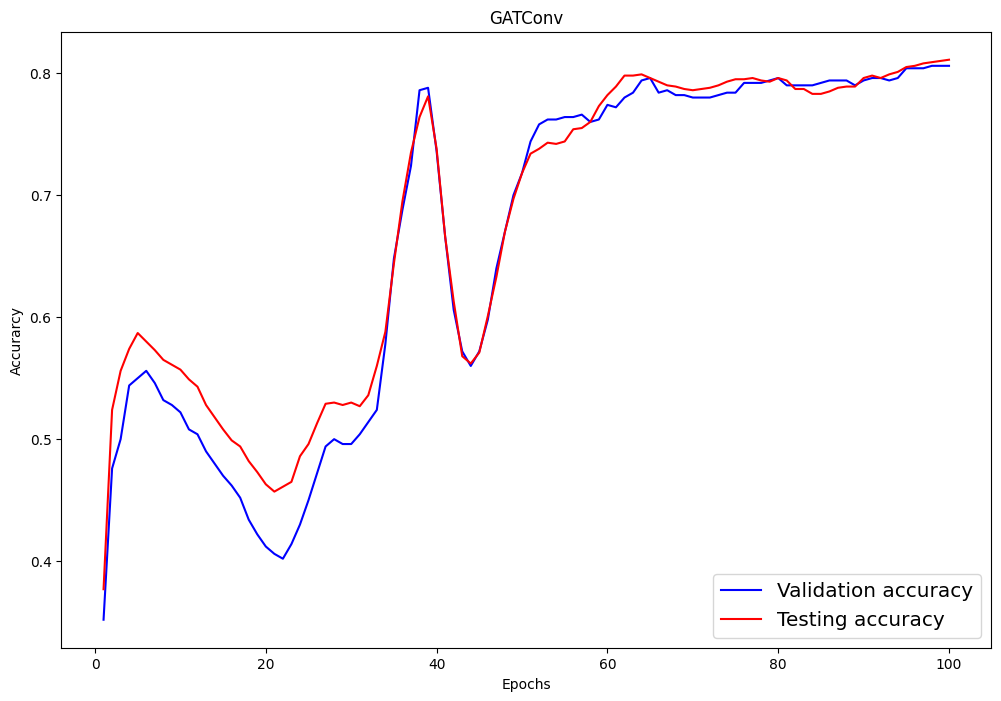

In [10]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(12,8))
plt.plot(np.arange(1, len(val_acc_all) + 1), val_acc_all, label='Validation accuracy', c='blue')
plt.plot(np.arange(1, len(test_acc_all) + 1), test_acc_all, label='Testing accuracy', c='red')
plt.xlabel('Epochs')
plt.ylabel('Accurarcy')
plt.title('GATConv')
plt.legend(loc='lower right', fontsize='x-large')
plt.savefig('gat_loss.png')
plt.show()

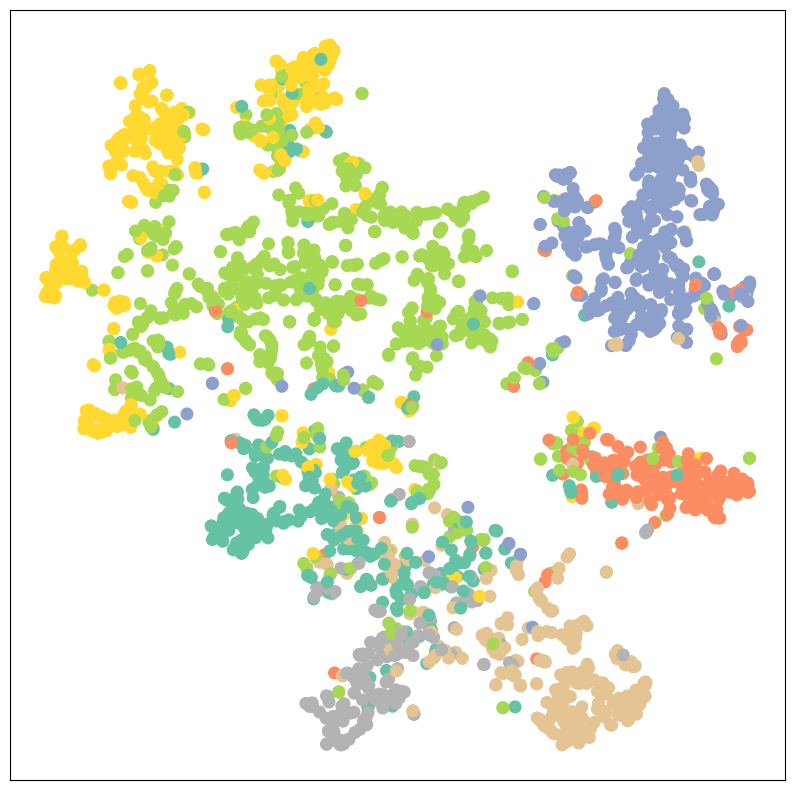

In [11]:
from sklearn.manifold import TSNE

def visualize(h, color):
    z = TSNE(n_components=2).fit_transform(h.detach().cpu().numpy())

    plt.figure(figsize=(10,10))
    plt.xticks([])
    plt.yticks([])

    plt.scatter(z[:, 0], z[:, 1], s=70, c=color, cmap="Set2")
    plt.show()
    
model.eval()

out = model(data.x, data.edge_index)
visualize(out, color=data.y)